# Análisis exploratorio

En este notebook vamos a realizar un análisis exploratorio que nos ayude a entender cómo se ha dado en el espacio la pandemia de COVID-19 en México. Intuitivamente la difusión de una epidemia es un fenómenos espacial, la enfermedad se transmite a través del contacto personal y, por lo tanto, es de esperarse que su evolución tenga una componente geográfica, es decir, que se observen estructuras espaciales (desde luego la estructura de contacto es más compleja dadas las redes de comunicación y comercio que existen).

En este análisis exploratorio vamos a hacer tres cosas, primero, examinar hasta qué punto podemos afirmar que la evolución de la pandemia en México ha seguido un patrón geográfico, interpretando esto como un patrón que muestre relación entre la incidencia de casos en un municpio y sus municipios vecinos.En segundo lugar, vamos a identificar los conglomerados locales de difusión de la enfermedad y, finalmente, haremos un análisis de la relación de dichos conglomerados locales con el índice de vulnerabilidad para tratar de identificar municipios que están en especial peligro.

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import glob
import splot
from splot.esda import moran_scatterplot
from esda.moran import Moran, Moran_Local, Moran_Local_BV
from splot.esda import lisa_cluster
from PIL import Image
import seaborn as sns
import sys
import contextily as ctx
plt.style.use('ggplot')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preproceso import get_confirmados_por_semana, get_defunciones_por_semana

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Asociacion espacial I de Moran

Para tener un primer estimado de qué tan _agrupada_ en el espacio ha sucedido la pandemia, vamos a hacer una serie de tiempo de la I de Moran a nivel municipal, tanto para la tasa de casos confirmados como para la tasa de defunciones.


Primero vamos a leer los datos y hacer agregados para cada semana epidemiológica (vamos a hacer el análisis temporal con base en semanas para evitar el ruido contenido en la variación diaria)

In [16]:
confirmados_por_semana = get_confirmados_por_semana("../data/200624COVID19MEXICO.csv")
confirmados_por_semana.head()

,municipio_cvegeo,total,acumulados
FECHA_INGRESO,,,
2020-01-19,01001,1.0,1.0
2020-01-26,01001,1.0,2.0
2020-02-02,01001,0.0,2.0
2020-02-09,01001,0.0,2.0
2020-02-16,01001,0.0,2.0


In [14]:
defunciones_por_semana = get_defunciones_por_semana("../data/200624COVID19MEXICO.csv")
defunciones_por_semana.head()

,municipio_cvegeo,total,acumulados
FECHA_DEF,,,
2020-03-22,01001,0.0,0.0
2020-03-29,01001,0.0,0.0
2020-04-05,01001,0.0,0.0
2020-04-12,01001,1.0,1.0
2020-04-19,01001,3.0,4.0


También vamos a necesitar las geometrías de los municipios y su población

In [22]:
muns_geo = gpd.read_file("../data/municipios.gpkg")
muns_geo.head()

,_uid_,entidad_cvegeo,municipio_cvegeo,municipio_nombre,pob,geometry
0,1,16,16046,Juárez,15290.0,"MULTIPOLYGON (((-100.45897 19.32952, -100.4588..."
1,2,16,16047,Jungapeo,22358.0,"MULTIPOLYGON (((-100.55704 19.51833, -100.5561..."
2,3,16,16048,Lagunillas,5862.0,"MULTIPOLYGON (((-101.38110 19.60250, -101.3811..."
3,4,16,16049,Madero,18769.0,"MULTIPOLYGON (((-101.11654 19.53720, -101.1168..."
4,5,05,05035,Torreón,744247.0,"MULTIPOLYGON (((-103.42797 25.30109, -103.3861..."


En `confirmados_por_semana` y `defunciones_por_semana` tenemos los casos y defunciones nuevas por cada semana respectivamente, entonces tenemos que acumularlos a lo largo de las semanas para tener los totales acumulados

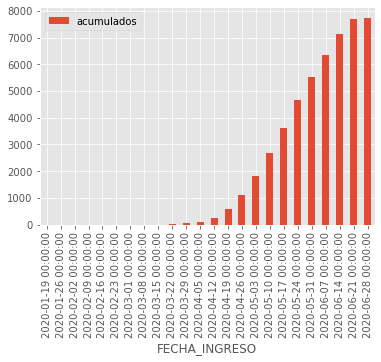

In [17]:
confirmados_por_semana = confirmados_por_semana.groupby(['municipio_cvegeo','FECHA_INGRESO'])[['acumulados']].sum()
confirmados_por_semana.xs('09007', level=0)[['acumulados']].plot(kind='bar')

Y lo mismo para las defunciones

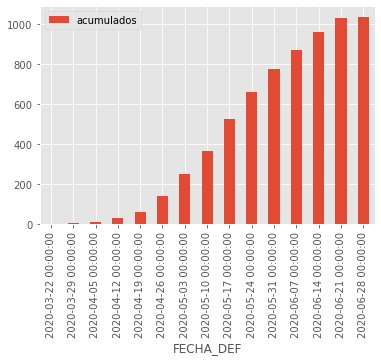

In [18]:
defunciones_por_semana = defunciones_por_semana.groupby(['municipio_cvegeo','FECHA_DEF'])[['acumulados']].sum()
defunciones_por_semana.xs('09007', level=0)[['acumulados']].plot(kind='bar')

### Autocorrelación para casos confirmados

Tenemos, por un lado, las geometrías (y poblaciones) de los municipios y, por otro lado, las series de tiempo de casos confirmados. Para calcular la I de Moran (o clusters de LISA) necesitamos tener las dos cosas unidas, por la forma en la que funcionan los métodos de PySal, lo más fácil es tener los datos en _forma ancha_, es decir, una columna por cada semana. 

In [19]:
confirmados_por_semana_wide = (confirmados_por_semana
                   .reset_index()
                   .pivot_table("acumulados", "municipio_cvegeo", "FECHA_INGRESO")
                  )
confirmados_por_semana_wide.head()

FECHA_INGRESO,2020-01-19,2020-01-26,2020-02-02,2020-02-09,2020-02-16,2020-02-23,2020-03-01,2020-03-08,2020-03-15,2020-03-22,...,2020-04-26,2020-05-03,2020-05-10,2020-05-17,2020-05-24,2020-05-31,2020-06-07,2020-06-14,2020-06-21,2020-06-28
municipio_cvegeo,,,,,,,,,,,,,,,,,,,,,
01001,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,11.0,...,170.0,253.0,352.0,455.0,556.0,748.0,1004.0,1312.0,1572.0,1589.0
01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,2.0,2.0,7.0,9.0,11.0,18.0,23.0,23.0
01003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,9.0,10.0,11.0,11.0,11.0,14.0,17.0,26.0,26.0
01004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,17.0,23.0,30.0,41.0,41.0
01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,13.0,17.0,22.0,27.0,33.0,38.0,49.0,59.0,60.0


Unimos con las geometrías de los municipios, tenemos que usar un right join y rellenar con ceros porque no todos los municipios tienen casos

In [23]:
confirmados_por_semana_wide = (confirmados_por_semana_wide
                   .merge(muns_geo, on='municipio_cvegeo', how='right')
                   .fillna(0))

confirmados_por_semana_wide.head()

,municipio_cvegeo,2020-01-19 00:00:00,2020-01-26 00:00:00,2020-02-02 00:00:00,2020-02-09 00:00:00,2020-02-16 00:00:00,2020-02-23 00:00:00,2020-03-01 00:00:00,2020-03-08 00:00:00,2020-03-15 00:00:00,...,2020-05-31 00:00:00,2020-06-07 00:00:00,2020-06-14 00:00:00,2020-06-21 00:00:00,2020-06-28 00:00:00,_uid_,entidad_cvegeo,municipio_nombre,pob,geometry
0,01001,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,...,748.0,1004.0,1312.0,1572.0,1589.0,430,01,Aguascalientes,961977.0,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036..."
1,01002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,11.0,18.0,23.0,23.0,431,01,Asientos,50864.0,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512..."
2,01003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,14.0,17.0,26.0,26.0,432,01,Calvillo,60760.0,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908..."
3,01004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,23.0,30.0,41.0,41.0,461,01,Cosío,16918.0,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875..."
4,01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,38.0,49.0,59.0,60.0,462,01,Jesús María,130184.0,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318..."


Con estos datos ya podemos calcular la I de Morán para cualquier semana. Como la matriz de pesos es la misma siempre, la podemos calcular antes

In [25]:
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 1286.
  warnings.warn(message)


2457

Hay una isla en los datos!

In [27]:
confirmados_por_semana_wide.iloc[1286]

municipio_cvegeo                                                   23001
2020-01-19 00:00:00                                                    0
2020-01-26 00:00:00                                                    0
2020-02-02 00:00:00                                                    0
2020-02-09 00:00:00                                                    0
2020-02-16 00:00:00                                                    0
2020-02-23 00:00:00                                                    0
2020-03-01 00:00:00                                                    0
2020-03-08 00:00:00                                                    0
2020-03-15 00:00:00                                                    0
2020-03-22 00:00:00                                                    0
2020-03-29 00:00:00                                                    3
2020-04-05 00:00:00                                                    7
2020-04-12 00:00:00                                

Claro, Cozumel es una isla, para que no moleste, la quitamos de los municipios y volvemos a calcular la matriz de contiguidad

In [29]:
confirmados_por_semana_wide = confirmados_por_semana_wide.drop([1286], axis=0)
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


2456

Para calcular la I de Moran para una semana en específico:

In [31]:
y = confirmados_por_semana_wide[pd.to_datetime('2020-06-21 00:00:00')] / confirmados_por_semana_wide['pob']
moran_c = Moran(y,w)
print("La I de Moran para la tasa de confirmados es: ", moran_c.I)
print("Su significancia : ", moran_c.p_sim)

La I de Moran para la tasa de confirmados es:  0.4456806627166928
Su significancia :  0.001


Calculamos la I de Moran sobre la tasa en lugar de sobre el total de casos para poder controlar por población (de lo contrario en realidad estaríamos viendo conglomerados de población). Ahora lo que queremos es sacar la serie de tiempo para la I de Moran de la tasa de casos confirmados para ver cómo ha evolucionado la aglomeración espacial de los casos. Hagamos la serie sólo para las últimas doce semanas, porque antes teníamos muy pocos casos como para que los resultados sean significativos

In [33]:
semanas_estudio = list(confirmados_por_semana_wide.columns)
semanas_estudio = [pd.to_datetime(s) for s in semanas_estudio 
                   if s not in ['municipio_cvegeo', '_uid_', 'entidad_cvegeo', 'municipio_nombre', 'pob', 'geometry']]
serie_moran_confirmados = []
for s in semanas_estudio:
    y = confirmados_por_semana_wide[s] / confirmados_por_semana_wide['pob']
    moran = Moran(y,w, permutations=1000)
    serie_moran_confirmados.append((s,moran.I, moran.p_sim))
df_moran_confirmados = pd.DataFrame(serie_moran_confirmados).rename({0:'fecha', 1:'I', 2:'p'}, axis=1)
df_moran_confirmados

,fecha,I,p
0,2020-01-19,-0.000747,0.426573
1,2020-01-26,-0.000747,0.443556
2,2020-02-02,-0.001251,0.430569
3,2020-02-09,-0.001507,0.422577
4,2020-02-16,-0.001649,0.422577
5,2020-02-23,-0.001764,0.419580
6,2020-03-01,0.001196,0.105894
7,2020-03-08,0.120192,0.000999
8,2020-03-15,0.070177,0.005994
9,2020-03-22,0.117720,0.000999


La I para las primeras 6 semanas no es significativa, entonces seleccionemos sólo los valores con $p > 0.05$

In [34]:
df_moran_confirmados = df_moran_confirmados[df_moran_confirmados['p'] < 0.05]
df_moran_confirmados

,fecha,I,p
7,2020-03-08,0.120192,0.000999
8,2020-03-15,0.070177,0.005994
9,2020-03-22,0.117720,0.000999
10,2020-03-29,0.012027,0.024975
11,2020-04-05,0.027795,0.015984
12,2020-04-12,0.059809,0.002997
13,2020-04-19,0.116009,0.000999
14,2020-04-26,0.190756,0.000999
15,2020-05-03,0.238276,0.000999
16,2020-05-10,0.283097,0.000999


Graficamos

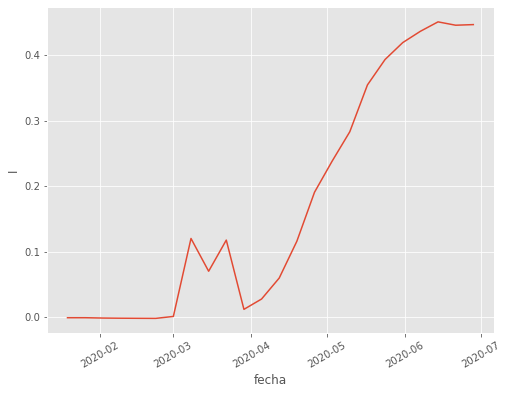

In [35]:
plt.figure(figsize=(8,6))
g = sns.lineplot(x="fecha", y="I", data=df_moran)
g = plt.setp(g.get_xticklabels(), rotation=30)

### Autocorrelación para la tasa de defunción

Ahora vamos a repetir el análisis pero para la tasa de defunción.

In [45]:
defunciones_por_semana_wide = (defunciones_por_semana
                   .reset_index()
                   .pivot_table("acumulados", "municipio_cvegeo", "FECHA_DEF")
                  )
defunciones_por_semana_wide = (defunciones_por_semana_wide
                   .merge(muns_geo, on='municipio_cvegeo', how='right')
                   .fillna(0))

defunciones_por_semana_wide.head()

,municipio_cvegeo,2020-03-22 00:00:00,2020-03-29 00:00:00,2020-04-05 00:00:00,2020-04-12 00:00:00,2020-04-19 00:00:00,2020-04-26 00:00:00,2020-05-03 00:00:00,2020-05-10 00:00:00,2020-05-17 00:00:00,...,2020-05-31 00:00:00,2020-06-07 00:00:00,2020-06-14 00:00:00,2020-06-21 00:00:00,2020-06-28 00:00:00,_uid_,entidad_cvegeo,municipio_nombre,pob,geometry
0,01001,0.0,0.0,0.0,1.0,4.0,5.0,8.0,16.0,22.0,...,41.0,58.0,81.0,99.0,101.0,430,01,Aguascalientes,961977.0,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036..."
1,01005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,2.0,2.0,2.0,462,01,Jesús María,130184.0,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318..."
2,01006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,3.0,4.0,4.0,463,01,Pabellón de Arteaga,50032.0,"MULTIPOLYGON (((-102.25130 22.18302, -102.2510..."
3,01007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,464,01,Rincón de Romos,57981.0,"MULTIPOLYGON (((-102.22684 22.37393, -102.2266..."
4,01011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,2.0,2.0,4.0,4.0,436,01,San Francisco de los Romo,51568.0,"MULTIPOLYGON (((-102.15100 22.08859, -102.1500..."


In [46]:
defunciones_por_semana_wide = defunciones_por_semana_wide.drop([1286, 818], axis=0)
w = Queen.from_dataframe(defunciones_por_semana_wide)
w.T = 'r' # estandarizamos por fila
w.n

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


2455

In [47]:
y = defunciones_por_semana_wide[pd.to_datetime('2020-06-21 00:00:00')] / defunciones_por_semana_wide['pob']
moran_d = Moran(y,w)
print("La I de Moran para la tasa de confirmados es: ", moran_d.I)
print("Su significancia : ", moran_d.p_sim)

La I de Moran para la tasa de confirmados es:  0.2851345443596301
Su significancia :  0.001


Finalmente, la serie de tiempo

In [48]:
semanas_estudio = list(defunciones_por_semana_wide.columns)
semanas_estudio = [pd.to_datetime(s) for s in semanas_estudio 
                   if s not in ['municipio_cvegeo', '_uid_', 'entidad_cvegeo', 'municipio_nombre', 'pob', 'geometry']]
serie_moran_defunciones = []
for s in semanas_estudio:
    y = defunciones_por_semana_wide[s] / defunciones_por_semana_wide['pob']
    moran = Moran(y,w, permutations=1000)
    serie_moran_defunciones.append((s,moran.I, moran.p_sim))
df_moran_defunciones = pd.DataFrame(serie_moran_defunciones).rename({0:'fecha', 1:'I', 2:'p'}, axis=1)
df_moran_defunciones

,fecha,I,p
0,2020-03-22,-0.001177,0.331668
1,2020-03-29,-0.000454,0.186813
2,2020-04-05,0.002760,0.114885
3,2020-04-12,0.007883,0.082917
4,2020-04-19,0.057803,0.009990
5,2020-04-26,0.107673,0.001998
6,2020-05-03,0.053589,0.005994
7,2020-05-10,0.081567,0.001998
8,2020-05-17,0.113433,0.000999
9,2020-05-24,0.165235,0.000999


Seleccionamos los estadísticamente significativos y graficamos

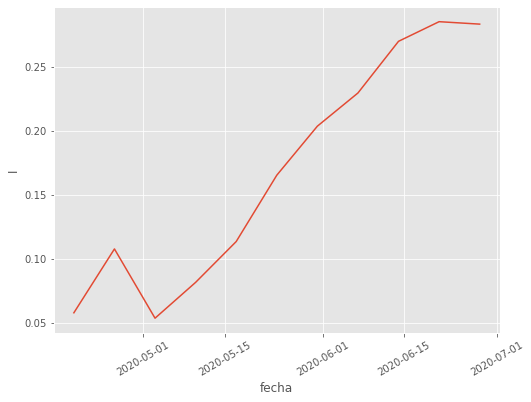

In [50]:
df_moran_defunciones = df_moran_defunciones[df_moran_defunciones['p'] < 0.05]
plt.figure(figsize=(8,6))
g = sns.lineplot(x="fecha", y="I", data=df_moran_defunciones)
g = plt.setp(g.get_xticklabels(), rotation=30)

Tenemos datos significativos para menos semanas y se observa una menor estructura espacial (I más pequeña), aunque de todos modos es significativa y positiva.
De alguna forma es un resultado esperado, la tasa de casos confirmados está diréctamente relacionada con el contacto entre personas, para lo cual la proximidad es un _proxy_, sin embargo la tasa de defunciones está mediada por otras características locales como la capacidad del sistema hospitalario y las comorbilidades de la población.

Ahora vamos a explorar las estructuras locales.

## Indicadores Locales de Asociación Espacial (LISA)

La I de Moran es un indicador _global_ de la Asociación espacial, sin embargo también es importante tener una idea de los conglomerados locales. Pra esto usamos LISA, que encuentra diferentes tipos de clusters locales. Como vimos arriba, la autocorrelación espacial cambia en el tiempo, de igual forma los conglomerados locales tabién pueden variar. En el siguiente Notebook vamos a estudiuar esta variación, por lo pronto veamos cómo son los conglomerados para la última semana. 

### Conglomerados para la tasa de confirmados

In [55]:
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
ultima_confirmados = confirmados_por_semana_wide[[pd.to_datetime('2020-06-28'), 'municipio_cvegeo', 'geometry', 'pob']].copy()
ultima_confirmados['tasa'] = ultima_confirmados[pd.to_datetime('2020-06-28')] / ultima_confirmados['pob']
ultima_confirmados.drop(pd.to_datetime('2020-06-28'), axis=1, inplace=True)
lisa_confirmados = Moran_Local.by_col(ultima_confirmados,'tasa',  w, permutations=10000, outvals=['q'])
# lisa_ultima = lisa_ultima.loc[:,['municipio_cvegeo', 'geometry', 'tasa,', 'tasa_p_sim', 'tasa_q']]
lisa_confirmados.rename({'tasa_q': 'cluster'}, inplace=True, axis=1)
lisa_confirmados.loc[lisa_confirmados['tasa_p_sim'] >= 0.05, 'cluster'] = -4
lisa_confirmados = gpd.geodataframe.GeoDataFrame(lisa_confirmados)
lisa_confirmados.crs = 'EPSG:4326'
lisa_confirmados['cluster'] = lisa_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
lisa_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,tasa_moran_local,cluster,tasa_p_sim
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,0.001652,-0.391671,NS,0.092091
1,01002,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512...",50864.0,0.000452,-0.061515,NS,0.157084
2,01003,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908...",60760.0,0.000428,0.013870,NS,0.488751
3,01004,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875...",16918.0,0.002423,0.296022,NS,0.285071
4,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,0.000461,-0.103356,NS,0.099790


Hacemos el mapa

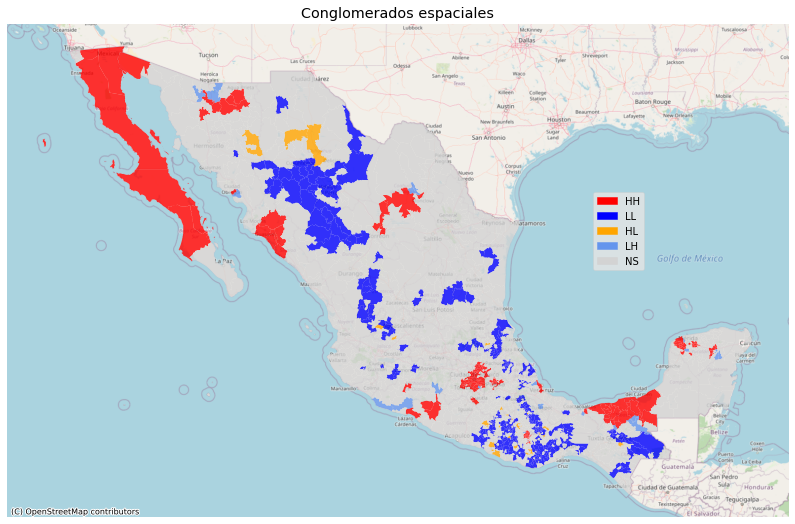

In [56]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in lisa_confirmados.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados espaciales para la tasa de confirmados')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Se encuentran los siguientes conglomerados:

* HH Valores altos de tasa de confiirmados en vecindades de valores altos, este tipo de conglomerado se conoce como _Hot Spot_
* LL Valores bajos de la tasa en vecindades con valores bajos, estos se llaman _Cold Spots_
* HL Valores altos en vecindades con valores bajos
* LH Valores bajos en vacindades con valores altos

Los conglomerados HH representan lugares donde se tiene una clara difusión espacial de la epidemia, mientra que los HH son lugares donde aún no se pŕesentan casos de forma significativa. Los calsos más interesantes son los HL y LH ya que ahí se vew una diferencia siginifcativa en la incidencia en municipios vecinos, son lugares en donde una intervensión puntual podría tener un efecto importante.

### Conglomerados para la tasa de defunciones

In [57]:
w = Queen.from_dataframe(defunciones_por_semana_wide)
w.T = 'r' # estandarizamos por fila
ultima_defunciones = defunciones_por_semana_wide[[pd.to_datetime('2020-06-28'), 'municipio_cvegeo', 'geometry', 'pob']].copy()
ultima_defunciones['tasa'] = ultima_defunciones[pd.to_datetime('2020-06-28')] / ultima_defunciones['pob']
ultima_defunciones.drop(pd.to_datetime('2020-06-28'), axis=1, inplace=True)
lisa_defunciones = Moran_Local.by_col(ultima_defunciones,'tasa',  w, permutations=10000, outvals=['q'])
# lisa_ultima = lisa_ultima.loc[:,['municipio_cvegeo', 'geometry', 'tasa,', 'tasa_p_sim', 'tasa_q']]
lisa_defunciones.rename({'tasa_q': 'cluster'}, inplace=True, axis=1)
lisa_defunciones.loc[lisa_defunciones['tasa_p_sim'] >= 0.05, 'cluster'] = -4
lisa_defunciones = gpd.geodataframe.GeoDataFrame(lisa_defunciones)
lisa_defunciones.crs = 'EPSG:4326'
lisa_defunciones['cluster'] = lisa_defunciones['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
lisa_defunciones.head()

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,municipio_cvegeo,geometry,pob,tasa,tasa_moran_local,cluster,tasa_p_sim
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,0.000105,-0.066227,HL,0.035896
1,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,0.000015,0.073400,NS,0.431457
2,01006,"MULTIPOLYGON (((-102.25130 22.18302, -102.2510...",50032.0,0.000080,0.001200,NS,0.185381
3,01007,"MULTIPOLYGON (((-102.22684 22.37393, -102.2266...",57981.0,0.000017,0.148482,NS,0.116988
4,01011,"MULTIPOLYGON (((-102.15100 22.08859, -102.1500...",51568.0,0.000078,0.003542,NS,0.433257


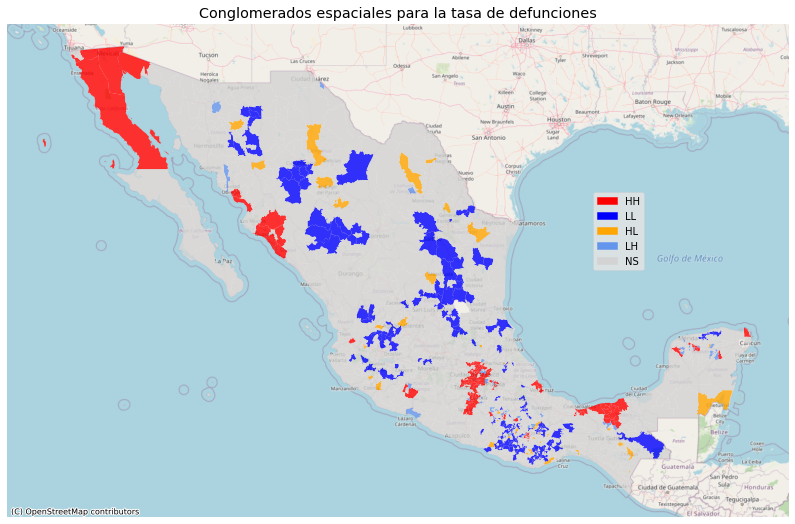

In [58]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in lisa_defunciones.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados espaciales para la tasa de defunciones')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Clusters locales bivariados

Finalmente, vamos a examinar los clusters locales bivariados usando como segunda variable el índice de vulnerabilidad. Los clusters bivariados miden las relaciones locales entre dos variables.


### Tasa de casos confirmados

Primero leemos el índice de vulnerabilidad y lo unimos a los datos

In [78]:
vulnerabilidad = pd.read_csv("../data/vulnerabilidad_200601.csv", dtype={"CLAVE_MUNICIPIO_RES":str, "CLAVE_ENTIDAD_RES":str})
vulnerabilidad = vulnerabilidad.loc[:,["CLAVE_MUNICIPIO_RES", "Vulnerabilidad"]]
bivariado_confirmados = lisa_confirmados.merge(vulnerabilidad, left_on='municipio_cvegeo', right_on='CLAVE_MUNICIPIO_RES')
bivariado_confirmados = bivariado_confirmados.drop(['tasa_moran_local', 'cluster', 'tasa_p_sim'], axis=1)
bivariado_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,CLAVE_MUNICIPIO_RES,Vulnerabilidad
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,0.001652,01001,8.602677
1,01002,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512...",50864.0,0.000452,01002,12.013766
2,01003,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908...",60760.0,0.000428,01003,11.776307
3,01004,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875...",16918.0,0.002423,01004,11.019018
4,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,0.000461,01005,10.072258


Queremos encontrar clusters locales en donde haya vecindades con alto número de casos rodeando a municipios con alta vulnerabilidad, entonces la variable para la que tenemos que calcular el retraso espacial es la tasa de confirmados.

Para asegurar que estamos calculando sobre la misma escala de medición, tenemos que estandarizar las variables que nos interesan a media 0 y varianza 1

In [79]:
bivariado_confirmados.loc[:,'tasa'] = (bivariado_confirmados['tasa'] - bivariado_confirmados['tasa'].mean())/bivariado_confirmados['tasa'].std()
bivariado_confirmados.loc[:,'Vulnerabilidad'] = (bivariado_confirmados['Vulnerabilidad'] - bivariado_confirmados['Vulnerabilidad'].mean())/bivariado_confirmados['Vulnerabilidad'].std()
bivariado_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,CLAVE_MUNICIPIO_RES,Vulnerabilidad
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,1.046911,01001,-1.868270
1,01002,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512...",50864.0,-0.187664,01002,-0.843496
2,01003,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908...",60760.0,-0.212645,01003,-0.914835
3,01004,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875...",16918.0,1.841043,01004,-1.142343
4,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,-0.178711,01005,-1.426772


In [80]:
w = Queen.from_dataframe(confirmados_por_semana_wide)
w.T = 'r' # estandarizamos por fila
local_bivar_confirmados = Moran_Local_BV.by_col(bivariado_confirmados,'Vulnerabilidad', 'tasa', w, permutations=10000, outvals=['q'])
local_bivar_confirmados.rename({'Vulnerabilidad-tasa_q': 'cluster'}, inplace=True, axis=1)
local_bivar_confirmados.loc[local_bivar_confirmados['Vulnerabilidad-tasa_p_sim'] > 0.05, 'cluster'] = -4
local_bivar_confirmados['cluster'] = local_bivar_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
local_bivar_confirmados = gpd.geodataframe.GeoDataFrame(local_bivar_confirmados)
local_bivar_confirmados.crs = "EPSG:4326"
local_bivar_confirmados.head()

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/home/datalab/app/env/lib/python3.7/site-packages/esda/moran.py:1163: RuntimeWarning: invalid value encountered in greater
  zp = self.zx > 0
/home/datalab/app/env/lib/python3.7/site-packages/esda/moran.py:1112: RuntimeWarning: invalid value encountered in greater_equal
  above = sim >= self.Is
/home/datalab/app/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/datalab/app/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/datalab/app/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 

,municipio_cvegeo,geometry,pob,tasa,CLAVE_MUNICIPIO_RES,Vulnerabilidad,Vulnerabilidad-tasa_moran_local_bv,cluster,Vulnerabilidad-tasa_p_sim
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,1.046911,01001,-1.868270,NaN,LL,0.0001
1,01002,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512...",50864.0,-0.187664,01002,-0.843496,NaN,LH,0.0001
2,01003,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908...",60760.0,-0.212645,01003,-0.914835,NaN,LL,0.0001
3,01004,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875...",16918.0,1.841043,01004,-1.142343,NaN,LH,0.0001
4,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,-0.178711,01005,-1.426772,NaN,LH,0.0001


El warning se puede deber a que hay valores nulos

In [81]:
bivariado_confirmados[bivariado_confirmados['Vulnerabilidad'].isna()]

,municipio_cvegeo,geometry,pob,tasa,CLAVE_MUNICIPIO_RES,Vulnerabilidad
177,08010,"MULTIPOLYGON (((-107.06067 30.80567, -107.0597...",25001.0,-0.570699,08010,NaN
210,08063,"MULTIPOLYGON (((-107.89776 29.24450, -107.8973...",7001.0,-0.359029,08063,NaN
211,08065,"MULTIPOLYGON (((-107.94560 27.60911, -107.9453...",22257.0,-0.560549,08065,NaN
910,20057,"MULTIPOLYGON (((-95.17098 17.31066, -95.17102 ...",40690.0,-0.248352,20057,NaN
1051,20427,"MULTIPOLYGON (((-94.94453 16.98243, -94.94503 ...",17112.0,-0.592885,20427,NaN
1208,21138,"MULTIPOLYGON (((-98.63444 19.15380, -98.63250 ...",12430.0,0.009331,21138,NaN
1416,26070,"MULTIPOLYGON (((-113.21021 31.99998, -113.0743...",18481.0,0.627758,26070,NaN
1871,20407,"MULTIPOLYGON (((-93.86743 17.13696, -93.88924 ...",9380.0,-0.653027,20407,NaN
1949,08024,"MULTIPOLYGON (((-106.36772 28.45089, -106.3674...",4293.0,-0.653027,08024,NaN
1988,08012,"MULTIPOLYGON (((-107.12334 28.11474, -107.1229...",10083.0,-0.653027,08012,NaN


En efecto, entonces tenemos que quitarlos y volver a calcular la matriz de pesos

In [82]:
bivariado_confirmados = bivariado_confirmados[bivariado_confirmados['Vulnerabilidad'].isna() == False]
w_bivar = Queen.from_dataframe(bivariado_confirmados)
w_bivar.T = 'r' # estandarizamos por fila
w_bivar.n

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


2445

Volvemos a calcular el LISA bivariado

In [83]:
local_bivar_confirmados = Moran_Local_BV.by_col(bivariado_confirmados,'Vulnerabilidad', 'tasa', w_bivar, permutations=10000, outvals=['q'])
local_bivar_confirmados.rename({'Vulnerabilidad-tasa_q': 'cluster'}, inplace=True, axis=1)
local_bivar_confirmados.loc[local_bivar_confirmados['Vulnerabilidad-tasa_p_sim'] > 0.05, 'cluster'] = -4
local_bivar_confirmados['cluster'] = local_bivar_confirmados['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
local_bivar_confirmados = gpd.geodataframe.GeoDataFrame(local_bivar_confirmados)
local_bivar_confirmados.crs = "EPSG:4326"
local_bivar_confirmados.head()

,municipio_cvegeo,geometry,pob,tasa,CLAVE_MUNICIPIO_RES,Vulnerabilidad,Vulnerabilidad-tasa_moran_local_bv,cluster,Vulnerabilidad-tasa_p_sim
0,01001,"MULTIPOLYGON (((-102.10641 22.06035, -102.1036...",961977.0,1.046911,01001,-1.868270,0.701145,NS,0.086691
1,01002,"MULTIPOLYGON (((-102.05189 22.29144, -102.0512...",50864.0,-0.187664,01002,-0.843496,-0.274573,NS,0.160484
2,01003,"MULTIPOLYGON (((-102.68569 22.09963, -102.6908...",60760.0,-0.212645,01003,-0.914835,0.061185,NS,0.483052
3,01004,"MULTIPOLYGON (((-102.28787 22.41649, -102.2875...",16918.0,1.841043,01004,-1.142343,-0.181380,NS,0.273673
4,01005,"MULTIPOLYGON (((-102.33348 22.05020, -102.3318...",130184.0,-0.178711,01005,-1.426772,-0.821352,NS,0.099290


Hacemos un mapa

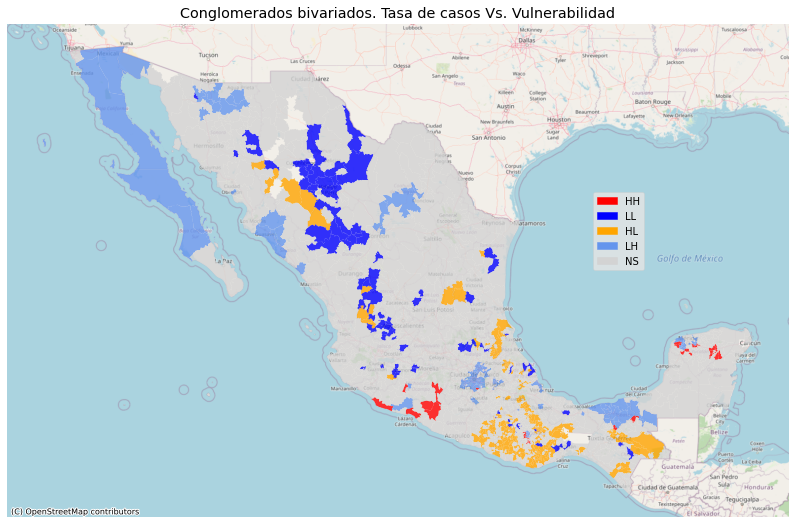

In [88]:
color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in local_bivar_confirmados.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados bivariados. Tasa de casos Vs. Vulnerabilidad')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Este mapa muestra otra vez cuatro tipos diferentes de conglomerados, en esta caso son un poco diferentes. LISA utiliza la autocorrelación con la misma variable, sin embargo en su versión bivariada, la segunda variable es la que tiene un retraso espacial, entonces los conglomerados que se encuentran muestran la asociación espacial local de la tasa de incidencia con la vulnerabilidad en los muncipios vecinos.

* Los conglomerados HH tienen alta tasa en vecindades con alta vulnerabilidad
* Los LL son regiones poco vulnerables y con tasa baja
* Los HL exhiben tasas elevadas en vecindades con baja vulnerabilidad
* LH tienen tasas bajas pero en vecindades muy vulnerables

En este caso los conglomerados que más llaman la atención son los HH porqe justo ahí se está dando una dispersión espacial hacia lugares con alta vulnerabilidad.

### Tasa de defunciones

/home/datalab/app/env/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


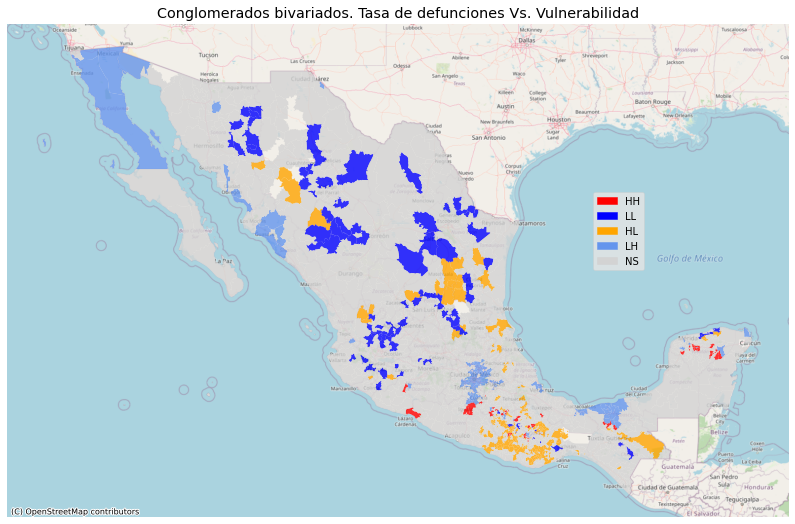

In [89]:
bivariado_defunciones = lisa_defunciones.merge(vulnerabilidad, left_on='municipio_cvegeo', right_on='CLAVE_MUNICIPIO_RES')
bivariado_defunciones = bivariado_defunciones.drop(['tasa_moran_local', 'cluster', 'tasa_p_sim'], axis=1)
bivariado_defunciones.loc[:,'tasa'] = (bivariado_defunciones['tasa'] - bivariado_defunciones['tasa'].mean())/bivariado_defunciones['tasa'].std()
bivariado_defunciones.loc[:,'Vulnerabilidad'] = (bivariado_defunciones['Vulnerabilidad'] - bivariado_defunciones['Vulnerabilidad'].mean())/bivariado_defunciones['Vulnerabilidad'].std()
bivariado_defunciones = bivariado_defunciones[bivariado_defunciones['Vulnerabilidad'].isna() == False]
w_bivar = Queen.from_dataframe(bivariado_defunciones)
w_bivar.T = 'r' # estandarizamos por fila
w_bivar.n
local_bivar_defunciones = Moran_Local_BV.by_col(bivariado_defunciones,'Vulnerabilidad', 'tasa', w_bivar, permutations=10000, outvals=['q'])
local_bivar_defunciones.rename({'Vulnerabilidad-tasa_q': 'cluster'}, inplace=True, axis=1)
local_bivar_defunciones.loc[local_bivar_defunciones['Vulnerabilidad-tasa_p_sim'] > 0.05, 'cluster'] = -4
local_bivar_defunciones['cluster'] = local_bivar_defunciones['cluster'].replace({1: 'HH', 2: 'LH', 3:'LL', 4:'HL', -4:'NS'})
local_bivar_defunciones = gpd.geodataframe.GeoDataFrame(local_bivar_defunciones)
local_bivar_defunciones.crs = "EPSG:4326"

color_dict = {'HH':'red', 'LL':'blue', 'HL':'orange', 'LH':'cornflowerblue', 'NS':'lightgray'}
fig, ax = plt.subplots(figsize=(14, 16))
for ctype, data in local_bivar_defunciones.groupby('cluster'):
    color = color_dict[ctype]
    # Plot each group using the color defined above
    data.to_crs(epsg=3857).plot(color=color,
              ax=ax,
              label=ctype,
              alpha=0.8 )

red_patch = mpatches.Patch(color='red', label='HH')
blue_patch = mpatches.Patch(color='blue', label='LL')
orange_patch = mpatches.Patch(color='orange', label='HL')
lblue_patch = mpatches.Patch(color='cornflowerblue', label='LH')
gray_patch = mpatches.Patch(color='lightgray', label='NS')
plt.legend(handles=[red_patch, blue_patch, orange_patch, lblue_patch, gray_patch], loc=(0.75,0.5))
ax.set(title='Conglomerados bivariados. Tasa de defunciones Vs. Vulnerabilidad')
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

En general, la interpretación de este mapa es similar a la de los conglomerados bivariados con la tasa de casos confirmados, aunque quizá sea menos informativo. Como vimos arriba, la tasa de casos tiene una clara estructura espacial que, además, obedece a la lógica de la epidemia: transimición por contacto. Sin embargo, no es claro que la tasa de defunciones obedezca a la misma lógica. Seguramente hay cierta estructura espacial porque a) las condiciones en lo municipios tienden a ser similares sólo por cercanía y b) las defunciones (en total) siguen una lógica parecida a la de los casos acumulados: entre más casos es más probable que haya defunciones.  